# Methods of De-treding
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [3]:
import nc_time_axis
import warnings

import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
import string


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

import os
import sys

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

In [30]:
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import time

logger = utils.get_notebook_logger()

In [6]:
notebook_number='02'

In [7]:
import dask.distributed as dd
import tempfile

tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dd.Client(local_directory=tempdir.name, memory_limit='16gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43979/status,
Dashboard: http://127.0.0.1:43979/status,Workers: 4
Total threads: 16,Total memory: 59.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40379,Workers: 4
Dashboard: http://127.0.0.1:43979/status,Total threads: 16
Started: Just now,Total memory: 59.60 GiB
Comm: tcp://127.0.0.1:42819,Total threads: 4
Dashboard: http://127.0.0.1:44073/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:39503,


# Loading Data

In [8]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]

In [12]:
control_abrupt_ds = open_ds.open_experiment_files(experiment_params, ExperimentTypes.CONTROL)
abrupt4x_ds = open_ds.open_experiment_files(experiment_params, ExperimentTypes.ABRUPT4X)



- /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped=
- Opening files in /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped
- Time lengths
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CCSM3_control_1530_g025.nc
- requested_length=100
- Removing first 10 steps
- Converting from Kelvin to C
- tas_mon_CCSM3_control_1530_g025.nc - 1520
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CESM104_control_1000_g025.nc
- requested_length=100
- Rename var='tas' to cesm104
- Converting from Kelvin to C
- tas_mon_CESM104_control_1000_g025.nc - 1000
- --- Running function 'read_longrunmip_netcdf'
- Opening files /g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped/tas_mon_CNRMCM61_control_2000_g025.nc
- requested_length=100
- Rename var='tas' to cnrmcm61
- Converting from Kelvin to C
- tas_mon_CNRMCM61_control_2

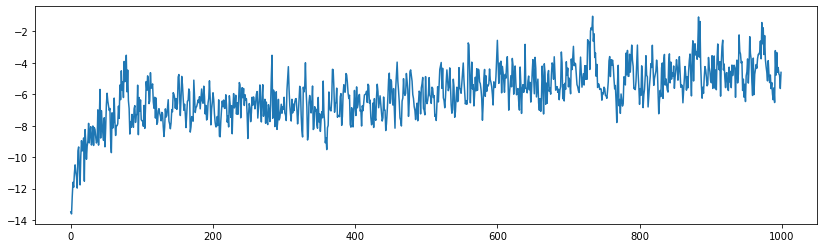

In [16]:
fig = plt.figure(figsize=(14,4))
plt.plot(abrupt4x_ds.isel(lat=-1, lon=0).ccsm3.values)

# Calculations

## Execution

In [133]:
SAVE_DIR = os.path.join(constants.LONGRUNMIP_DIR, experiment_params['variable'], 'trend_fitted_1000y')
SAVE_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y'

In [131]:
start_time = time.perf_counter()

method = 'polynomial'
orders = (2,3,4,5,6)

polynomial_to_save = {}
for order in orders:
    print(f'{order=}', end='')
    ds = stats.trend_fit(abrupt4x_ds, method=method, order=order)
    polynomial_to_save[order] = ds
    print(f'- {time.perf_counter() - start_time} seconds')

order=2- 57.51983707398176 seconds
order=3- 116.84437557402998 seconds
order=4- 180.6756917508319 seconds
order=5- 249.1938598959241 seconds
order=6- 319.5277628728654 seconds


In [134]:
for order, ds in polynomial_to_save.items():
    path = os.path.join(SAVE_DIR, f'polynomial_{order}.nc')
    print(path)
    ds.to_netcdf(path)

/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/polynomial_2.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/polynomial_3.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/polynomial_4.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/polynomial_5.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/polynomial_6.nc


In [135]:
start_time = time.perf_counter()

method = 'lowess'
lowess_windows = (20, 50, 100)

lowess_to_save = {}
for lowess_window in lowess_windows:
    print(f'{lowess_window=}', end='')
    ds = stats.trend_fit(abrupt4x_ds, method=method, lowess_window=lowess_window)
    lowess_to_save[lowess_window] = ds
    print(f'- {time.perf_counter() - start_time} seconds')

lowess_window=20- 28444.36655399087 seconds
lowess_window=50- 57714.64124307386 seconds
lowess_window=100- 87377.689751409 seconds


In [136]:
for lowess_window, ds in polynomial_to_save.items():
    path= os.path.join(SAVE_DIR, f'lowess_{lowess_window}.nc')
    print(path)
    ds.to_netcdf(path)

/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/lowess_2.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/lowess_3.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/lowess_4.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/lowess_5.nc
/g/data/w40/ab2313/PhD/longrunmip/tas/trend_fitted_1000y/lowess_6.nc
